# Minimum Variance Portfolio Optimization with WRDS (CRSP Monthly Data)

This notebook demonstrates how to:
- Pull monthly stock return data from WRDS/CRSP
- Clean and validate coverage
- Estimate covariance matrices using **sample** and **Ledoit-Wolf shrinkage**
- Solve the **Global Minimum Variance (GMV)** portfolio with constraints
- Run a **rolling out-of-sample backtest**
- Compute metrics: annualized return, volatility, Sharpe ratio
- Analyze **turnover** and **weight stability**
- Export results and plots for reporting

In [3]:
# pip install cvxpy

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import wrds
from pandas.tseries.offsets import MonthEnd
from tqdm import tqdm

def data_acquisition():

    # Connect to WRDS database
    db = db_connect()

    # Get user inputs
    tickers = ticker_input()
    start_date_eval, look_back_period = date_input()
    max_missing = missing_months_input()
    all_data = pd.DataFrame()

    shrcd_list = [10, 11]  # Common shares

    permno_list, valid_tickers = get_active_permnos(
        db, tickers, start_date_eval, max_missing, shrcd_list)

    # Get returns data
    all_data = get_returns(
        db, permno_list, start_date_eval.strftime('%Y-%m-%d'))
    
    permno_to_ticker = dict(zip(permno_list, valid_tickers))
    all_data = all_data.rename(columns=permno_to_ticker)

    max_weight, min_weight = weight_constraint_input()

    end_date_eval = all_data.index.max()
    risk_free_rate_series = get_risk_free_rate_series(
        db, start_date_eval, end_date_eval)

    df_full = get_crsp_monthly_panel(
        db, permno_list, start_date_eval.strftime('%Y-%m-%d'))
    
    db.close()

    return all_data, valid_tickers, permno_list, start_date_eval, look_back_period, \
        max_weight, min_weight, risk_free_rate_series, df_full


def db_connect():
    # Connect to WRDS database
    try:
        db = wrds.Connection(wrds_username='rio_yoko',
                             wrds_password='yokoyama0928')
        # db = wrds.Connection()
        print("Connected to WRDS database.")
        return db
    except Exception as e:
        print("Failed to connect to WRDS database:", e)
        raise


def ticker_input():
    # Ask the user for a list of tickers (comma separated) with error handling
    while True:
        # Split by comma and strip whitespace and remove "
        tickers = input(
            "Enter a list of stock tickers (comma separated): ").split(',')
        tickers = [ticker.strip().upper() for ticker in tickers]
        tickers = [ticker.replace('"', '').replace("'", '')
                   for ticker in tickers]
        if not tickers or tickers == ['']:
            print("Invalid input. Please enter at least one ticker.")
        else:
            break
    print(f"Tickers: {tickers}")
    return tickers


def date_input():
    """
    Prompt for a start date (YYYY-MM-DD) and number of months (positive int),
    then return (start_date, number of months).
    """
    while True:
        try:
            start_str = input("Enter the start date (YYYY-MM-DD): ").strip()
            months_str = input(
                "Enter the number of months for the look back period: ").strip()

            # strict date parsing (won't accept "0")
            start_date = dt.strptime(start_str, "%Y-%m-%d")
            num_months = int(months_str)

            if num_months <= 0:
                print("Number of months must be a positive integer. Please try again.")
                continue

            end_date = pd.Timestamp(start_date) + \
                pd.DateOffset(months=num_months-1)
            print(
                f"Date range: {pd.Timestamp(start_date).date()} to {end_date.date()}")
            return pd.Timestamp(start_date), num_months

        except ValueError:
            print(
                "Invalid input. Use YYYY-MM-DD for the date and a positive integer for months.")


def missing_months_input():
    # Ask the user for the maximum number of allowed missing months with error handling
    while True:
        try:
            max_missing = int(
                input("Enter the maximum number of allowed missing months: "))
            if max_missing < 0:
                print("Please enter a non-negative integer.")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a non-negative integer.")
    print(f"Maximum allowed missing months: {max_missing}")
    return max_missing


def get_active_permnos(db, tickers: list, start_date: pd.Timestamp, max_missing: int, shrcd_list: list):
    """
    Get active PERMNOs for the given tickers and date range.
    """
    permno_list = []
    valid_tickers = []
    # date_of_delisting = []

    for ticker in tickers:
        # If there is no valid PERMNO found, ask the user for a replacement ticker
        permno = pick_permno_for_ticker(
            db, ticker, start_date, max_missing, shrcd_list)
        while permno is None:
            print(f"No valid PERMNO found for ticker {ticker}.")
            ticker = input(
                "Please enter a replacement ticker: ").strip().upper()
            permno = pick_permno_for_ticker(
                db, ticker, start_date, max_missing, shrcd_list)
        permno_list.append(permno)
        valid_tickers.append(ticker)
        # date_of_delisting.append(delisting_date)

    print(f"Final tickers used: {valid_tickers}")
    print(f"Corresponding PERMNOs: {permno_list}")
    # print(f"Collecting data until first delisting date (if any): {max(date_of_delisting)}")

    return permno_list, valid_tickers


def pick_permno_for_ticker(db, ticker: str, start_date: pd.Timestamp, max_missing: int,
                           shrcd_list: list) -> int | None:
    """
    Given a ticker and a date, pick the most appropriate PERMNO.

    Criteria (in order):
    1) Active on the start_date
    2) If multiple, pick the one with the namedt earliest

    Returns
    -------
    Selected PERMNO or None if no valid PERMNO found. Delisting dates.
    """
    q = f"""
    SELECT
        n.permno,
        n.namedt,
        n.nameendt,
        n.exchcd,
        n.shrcd
    FROM crsp.msenames AS n
    WHERE n.ticker = '{ticker}'
    ORDER BY n.namedt;
    """
    df = db.raw_sql(q)

    df['namedt'] = pd.to_datetime(df['namedt'])
    # df['nameendt'] = pd.to_datetime(df['nameendt'])
    # df['nameendt'] = df['nameendt'].fillna(pd.Timestamp.max)

    # print(ticker, start_date, max_missing, shrcd_list)
    # print(df)

    if df.empty:
        return None

    df = df[df['shrcd'].isin(shrcd_list)]

    if df.empty:
        # Nothing in the allowed share codes
        print(
            f"Ticker {ticker} has no active PERMNOs in common share classes as of {start_date.date()}.")
        return None

    df = collapse_name_ranges(df)

    # end_date = pd.Timestamp.today()
    # 1) Exact coverage: [namedt, nameendt] fully covers [start_date, end_date]
    # mask_full = (df['namedt'] <= start_date) & (df['nameendt'] >= end_date)
    active = df[df['namedt'] <= start_date]
    if active.empty:
        print(
            f"Ticker {ticker} has no active PERMNOs as of {start_date.date()}.")
        return None

    # iterate rows so we can grab shrcd for the same permno
    for _, row in active.iterrows():
        permno = int(row['permno'])

        df1 = get_delistings(db, [permno], start_date.strftime('%Y-%m-%d'))
        df2 = get_returns(db, [permno], start_date.strftime(
            '%Y-%m-%d'), max_missing)

        if df1.empty and isinstance(df2, pd.DataFrame) and not df2.empty:
            return permno
        elif not df1.empty:
            print('Delisting data found for PERMNO:', permno)
            print(df1)

    return None


def collapse_name_ranges(df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge rows per permno when the next segment starts the day after (or earlier than)
    the previous segment ends (i.e., overlapping or touching intervals).

    Keeps only: permno, namedt, nameendt
    """
    out = df.copy()
    out['namedt'] = pd.to_datetime(out['namedt'])
    out['nameendt'] = pd.to_datetime(
        out['nameendt']).fillna(pd.Timestamp('9999-12-31'))

    # sort within permno by start then end
    out = out.sort_values(['permno', 'namedt', 'nameendt'])

    # previous end per permno
    prev_end = out.groupby('permno')['nameendt'].shift()

    # start a new group when there is a gap (> 1 day). If you want to merge *only*
    # exactly-adjacent segments (next_start == prev_end + 1 day) and NOT overlaps,
    # see the note below.
    is_new_group = (prev_end.isna()) | (
        out['namedt'] > (prev_end + pd.Timedelta(days=1)))

    # running group id per permno
    out['grp'] = is_new_group.groupby(out['permno']).cumsum()

    # aggregate each group to a single interval
    merged = (
        out.groupby(['permno', 'grp'])
        .agg(namedt=('namedt', 'min'), nameendt=('nameendt', 'max'))
        .reset_index()
    )
    # print(merged)

    return merged[['permno', 'namedt', 'nameendt']]


def get_returns(df_conn, permno_list: list, start: str, max_missing=None) -> pd.DataFrame:
    """
    Wide monthly returns: index=date (Timestamp), columns=permno (int), values=ret (float).
    Missing/non-numeric RET are filled with 0.0 (policy choice).
    """
    if not permno_list:
        return pd.DataFrame()

    permno_list = [int(p) for p in permno_list]
    q = f"""
        SELECT permno, date, ret
        FROM crsp.msf
        WHERE permno IN ({','.join(map(str, permno_list))})
          AND date >= '{start}'
        ORDER BY permno, date;
    """
    d = df_conn.raw_sql(q)
    if d.empty:
        return pd.DataFrame(index=pd.DatetimeIndex([], name='date'))

    d['date'] = pd.to_datetime(d['date']) + MonthEnd(0)  # ensure month-end
    d['ret'] = pd.to_numeric(d['ret'], errors='coerce')

    # Count missing per PERMNO BEFORE filling
    if d['ret'].isna().any():
        miss_counts = d.loc[d['ret'].isna()].groupby('permno')['ret'].size()
    else:
        # no missing -> zeros for all seen permnos
        miss_counts = pd.Series(0, index=d['permno'].unique(), name='ret')

    # Enforce per-PERMNO missing threshold (if requested)
    if max_missing is not None:
        bad_permnos = miss_counts[miss_counts > max_missing]
        if not bad_permnos.empty:
            print(
                f"Warning: dropping PERMNOs exceeding allowed missing months ({max_missing}): "
                f"{sorted(map(int, bad_permnos.index.tolist()))}"
            )
            d = d[~d['permno'].isin(bad_permnos.index)]

    # If everything was dropped, return an empty, well-formed frame
    if d.empty:
        return pd.DataFrame(index=pd.DatetimeIndex([], name='date'))

    # Fill remaining missing to 0.0 (policy choice)
    n_missing_remaining = d['ret'].isna().sum()
    if n_missing_remaining:
        print(
            f"Info: {n_missing_remaining} missing returns (after filtering) "
            f"coerced to 0.0 across {d['permno'].nunique()} PERMNO(s)."
        )
        d['ret'] = d['ret'].fillna(0.0)

    wide = (
        d.pivot(index='date', columns='permno', values='ret')
        .sort_index()
        .rename_axis(index='date', columns='permno')
        .astype(float)
    )
    return wide


def get_delistings(db, permno_list: list, start: str) -> pd.DataFrame:
    """
    Delisting returns aligned to month-end for merging with monthly CRSP returns.
    Returns long DataFrame with columns: permno (int), date (Timestamp month-end), dlret (float).
    """
    if not permno_list:
        return pd.DataFrame(columns=['permno', 'date', 'dlret'])

    permno_list = [int(p) for p in permno_list]
    q = f"""
        SELECT permno, dlstdt, dlret
        FROM crsp.msedelist
        WHERE permno IN ({','.join(map(str, permno_list))})
          AND dlstdt >= '{start}'
          AND dlret IS NOT NULL
        ORDER BY permno, dlstdt;
    """
    df = db.raw_sql(q)
    if df.empty:
        return pd.DataFrame(columns=['permno', 'date', 'dlret'])

    df['date'] = pd.to_datetime(df['dlstdt']) + \
        MonthEnd(0)  # align to month-end
    df['dlret'] = pd.to_numeric(df['dlret'], errors='coerce')
    df = df[['permno', 'date', 'dlret']].dropna(subset=['dlret'])
    df['permno'] = df['permno'].astype(int)
    return df


def add_effective_returns(panel_wide: pd.DataFrame, delist_long: pd.DataFrame) -> pd.DataFrame:
    """
    Merge delisting returns into a wide monthly returns panel and compute effective returns:
        ret_eff = (1 + ret) * (1 + dlret) - 1
    Returns a wide DataFrame with the same shape (date x permno), values=ret_eff.
    - If a month has both ret and dlret, they compound.
    - If only one is present, the other is treated as 0 (no effect).
    """
    if panel_wide.empty:
        return panel_wide
    if delist_long.empty:
        return panel_wide

    panel_wide = panel_wide.rename_axis(index="date", columns="permno")

    # Wide -> long for merge
    long = (
        panel_wide.stack()
        .rename('ret')
        .reset_index()
        # not needed if columns already named 'permno'
        .rename(columns={'level_1': 'permno'})
    )
    # Ensure correct dtypes
    long['permno'] = long['permno'].astype(int)
    long['date'] = pd.to_datetime(long['date'])

    # Merge and compute effective returns
    merged = long.merge(delist_long, on=['permno', 'date'], how='left')
    merged['ret'] = pd.to_numeric(merged['ret'], errors='coerce').fillna(0.0)
    merged['dlret'] = pd.to_numeric(
        merged['dlret'], errors='coerce').fillna(0.0)
    merged['ret_eff'] = (1.0 + merged['ret']) * (1.0 + merged['dlret']) - 1.0

    # Long -> wide
    out = (
        merged.pivot(index='date', columns='permno', values='ret_eff')
        .sort_index()
        .rename_axis(index='date', columns='permno')
        .astype(float)
    )

    # Preserve original index/columns union (optional)
    out = out.reindex(index=panel_wide.index.union(out.index)).reindex(
        columns=panel_wide.columns, fill_value=out.reindex(columns=panel_wide.columns))
    # align to original dates/permnos
    out = out.reindex(index=panel_wide.index, columns=panel_wide.columns)
    return out


def weight_constraint_input():
    def ask_yn(prompt: str) -> str:
        while True:
            ans = input(prompt).strip().lower()
            if ans in {"y", "n"}:
                return ans
            print("Please answer 'y' or 'n'.")

    # ---- max (long) constraint ----
    set_max = ask_yn("Do you want to set maximum weight constraints? (y/n): ")
    max_weight = None
    if set_max == "y":
        while True:
            try:
                max_weight = float(
                    input("Enter the maximum long position (e.g., 0.1 for 10%): ").strip())
                if max_weight <= 0:
                    print("Please enter a positive number.")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a positive number.")
        print(f"Maximum long position: {max_weight}")
    else:
        print("No maximum weight constraints set.")

    # ---- min (short) constraint ----
    set_min = ask_yn(
        "Do you want to set maximum short position constraints? (y/n): ")
    min_weight = None
    if set_min == "y":
        while True:
            try:
                min_weight = float(
                    input("Enter the maximum short position (e.g., -0.1 for -10%): ").strip())
                if min_weight > 0:
                    print("Please enter a negative number (or zero for no shorting).")
                    continue
                break
            except ValueError:
                print("Invalid input. Please enter a negative number.")
        print(f"Maximum short position: {min_weight}")
    else:
        print("No minimum weight constraints set.")

    return max_weight, min_weight


def window_size_input():
    # Ask the user for the rolling window size (in months) with error handling
    while True:
        try:
            window_size = int(
                input("Enter the rolling window size (in months) for out-of-sample testing: "))
            if window_size <= 0:
                print("Please enter a positive integer.")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a positive integer.")
    print(f"Rolling window size: {window_size} months")
    return window_size


def risk_free_rate_input():
    # Ask the user for the annual risk-free rate (as a decimal) with error handling
    while True:
        try:
            rf_rate = float(
                input("Enter the annual risk-free rate (as a decimal, e.g., 0.03 for 3%): "))
            if rf_rate < 0:
                print("Please enter a non-negative number.")
            else:
                break
        except ValueError:
            print("Invalid input. Please enter a non-negative number.")
    print(f"Annual risk-free rate: {rf_rate}")
    return rf_rate


def get_risk_free_rate_series(db, start, end) -> pd.DataFrame:
    rf = db.get_table(library='ff', table='factors_monthly')[['date', 'rf']]
    rf['date'] = pd.to_datetime(rf['date']) + MonthEnd(0)   # ensure month-end
    rf = rf.rename(columns={'rf': 'risk_free_rate'})
    rf = rf[(rf['date'] >= start) & (rf['date'] <= end)]
    rf.set_index('date', inplace=True)
    return rf


def get_crsp_monthly_panel(db, permono_list: list, start_date: str) -> pd.DataFrame:
    """
    Pull the CRSP monthly panel *with* security descriptors via a time-bounded
    join to msenames (since shrcd/exchcd live in the name-history tables).

    Filters (can be edited):
      - U.S. common stocks: shrcd in (10, 11)
      - Major exchanges   : exchcd in (1, 2, 3)  # NYSE, AMEX, NASDAQ

    Returns
    -------
    DataFrame with date, permno, prc, shrout, ret, retx, shrcd, exchcd,
    and a computed market cap (mktcap).
    """
    # Convert start/end to Timestamps
    start_dt = pd.to_datetime(start_date)
    
    q = f"""
    SELECT
        m.date,
        m.permno,
        m.permco,
        m.prc,
        m.shrout,
        m.ret,
        m.retx,
        n.shrcd,
        n.exchcd,
        n.ticker
    FROM crsp.msf AS m
    JOIN crsp.msenames AS n
        ON m.permno = n.permno
        AND m.date BETWEEN n.namedt AND COALESCE(n.nameendt, '9999-12-31') 
        -- A given stock (permno) can have multiple records in msenames over time: ticker changes, exchange moves, share code reclassifications, mergers.
    WHERE m.date >= '{start_date}'
        AND m.permno IN ({','.join(map(str, permono_list))})
        AND m.prc    IS NOT NULL
        AND m.shrout IS NOT NULL
    ORDER BY m.date, m.permno;
    """

    # frames.append(db.raw_sql(q))

    # Concatenate all yearly chunks
    df = db.raw_sql(q)

    # ---- Standardize dtypes and construct market cap ----
    if not df.empty:
        df["date"] = pd.to_datetime(df["date"]) + MonthEnd(0)  # ensure month-end
        # CRSP price may be negative (indicating a bid/ask mid)
        df["prc"] = pd.to_numeric(df["prc"], errors="coerce").abs()
        df["shrout"] = pd.to_numeric(
            df["shrout"], errors="coerce") * 1000.0  # in thousands of shares
        df["ret"] = pd.to_numeric(
            df.get("ret", pd.Series()),   errors="coerce")
        df["retx"] = pd.to_numeric(
            df.get("retx", pd.Series()),  errors="coerce")
        df["mktcap"] = df["prc"] * df["shrout"]
        # set the index of the df to dates
        # df = df.set_index('date').sort_index()

    return df


# if __name__ == "__main__":
#     data_acquisition()


In [5]:
import numpy as np
import pandas as pd
import cvxpy as cp
import os
import sys
import math
from copy import deepcopy
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

def returns_to_excess(returns: pd.DataFrame, rf_df: pd.DataFrame | pd.Series) -> pd.DataFrame:
    # If rf_df is a 1-col DataFrame, squeeze to a Series
    out = deepcopy(returns)
    rf = rf_df.squeeze() if isinstance(rf_df, pd.DataFrame) else rf_df
    # Align by index (in case one has extra/missing dates)
    rf = rf.reindex(out.index)
    # Vectorized row-wise subtraction across all columns
    out = out.sub(rf, axis=0)
    return out


def sample_covariance(ret_window):
    return ret_window.cov().values


def ledoit_wolf_covariance(ret_window):
    lw = LedoitWolf().fit(ret_window.values)
    return lw.covariance_


def gmv_weights(cov_matrix, lower_bound=None, upper_bound=None):
    n = cov_matrix.shape[0]
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, cov_matrix))
    constraints = [cp.sum(w) == 1]
    # Add maximum weight constraints if specified
    if upper_bound is not None:
        constraints.append(w <= upper_bound)
    # Add minimum weight constraints if specified
    if lower_bound is not None:
        constraints.append(w >= lower_bound)
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)
    return np.array(w.value).ravel()


def backtest_minvar(raw_returns_wide, excess_returns_wide, window_months=36,
                    lower_bound=None, upper_bound=None):
    dates = excess_returns_wide.index
    tickers = list(excess_returns_wide.columns)
    perf_rows, weight_rows = [], []

    for t in range(window_months, len(dates) - 1):
        est_window = excess_returns_wide.iloc[t - window_months: t]
        # print(est_window.shape)
        next_raw_ret = raw_returns_wide.iloc[t + 1].values
        next_excess_ret = excess_returns_wide.iloc[t + 1].values

        s_cov = sample_covariance(est_window)
        lw_cov = ledoit_wolf_covariance(est_window)

        w_sample = gmv_weights(s_cov, lower_bound, upper_bound)
        w_lw = gmv_weights(lw_cov, lower_bound, upper_bound)

        perf_rows.append({
            "date": dates[t + 1],
            "sample_return": np.dot(w_sample, next_raw_ret),
            "lw_return": np.dot(w_lw, next_raw_ret),
            "sample_excess_return": np.dot(w_sample, next_excess_ret),
            "lw_excess_return": np.dot(w_lw, next_excess_ret)
        })

        for i, tic in enumerate(tickers):
            weight_rows.append(
                {"date": dates[t], "method": "sample", "ticker": tic, "weight": w_sample[i]})
            weight_rows.append(
                {"date": dates[t], "method": "ledoit_wolf", "ticker": tic, "weight": w_lw[i]})

    perf_df = pd.DataFrame(perf_rows).sort_values(
        "date").reset_index(drop=True)
    perf_df["sample_cum"] = (1 + perf_df["sample_return"]).cumprod()
    perf_df["lw_cum"] = (1 + perf_df["lw_return"]).cumprod()
    weights_df = pd.DataFrame(weight_rows)
    return perf_df, weights_df


def summarize_performance(perf_df):
    # summarize performance
    summary = []
    for label, col1, col2 in [("sample", "sample_return", "sample_excess_return"),
                              ("ledoit_wolf", "lw_return", "lw_excess_return"),
                              ("equal_weighted", "ew_return", "ew_excess_return"),
                              ("value_weighted", "vw_return", "vw_excess_return"),
                              ("price_weighted", "pw_return", "pw_excess_return")]:
        ann_mean, ann_std = annualize_mean_std(perf_df[col1])
        sr = sharpe_ratio(perf_df[col2])
        summary.append({"strategy": label, "annual_return": ann_mean,
                        "annual_volatility": ann_std, "sharpe_ratio": sr})
    summary_df = pd.DataFrame(summary)
    return summary_df


def annualize_mean_std(monthly_returns):
    mean_monthly = monthly_returns.mean()
    std_monthly = monthly_returns.std(ddof=1)
    ann_mean = (1 + mean_monthly) ** 12 - 1
    ann_std = std_monthly * math.sqrt(12)
    return ann_mean, ann_std


def sharpe_ratio(monthly_excess_returns):
    # monthly_rf = (1 + annual_rf) ** (1/12) - 1
    # excess = monthly_returns - monthly_rf
    sharpe = math.sqrt(12) * (monthly_excess_returns.mean()) / (monthly_excess_returns.std(ddof=1) if monthly_excess_returns.std(ddof=1) != 0 else np.nan)
    return sharpe


# ========= output helpers (all functions, clean + commented) =========
def turnover_series(weight_list: pd.DataFrame):
    # --- Turnover (per month) ---\
    # Turnover ≈ 0.5 * Σ_i |w_t,i − w_{t−1,i}|
    if isinstance(weight_list, pd.DataFrame) and not weight_list.empty:
        W = weight_list.sort_index()
        dW = W.diff().abs()
        turnover = 0.5 * dW.sum(axis=1)
        turnover = turnover.iloc[1:]  # drop first (NaN) period
        turnover.name = "turnover"
    else:
        turnover = pd.Series(dtype=float, name="turnover")

    return turnover


def compute_turnover(weights_df):
    """
    Turnover ≈ 0.5 * Σ_i |w_t,i − w_{t−1,i}|
    weights_df : long-form DataFrame with ['date','method','ticker','weight']
    returns     : DataFrame with ['date','method','turnover']
    """
    out = []
    for method in weights_df['method'].unique():
        w = (weights_df[weights_df['method'] == method]
             .pivot(index='date', columns='ticker', values='weight')
             .sort_index())
        for i in range(1, len(w)):
            prev, curr = w.iloc[i-1].values, w.iloc[i].values
            out.append({
                'date': w.index[i],
                'method': method,
                'turnover': float(0.5 * np.sum(np.abs(curr - prev)))
            })
    return pd.DataFrame(out)


def compute_weight_stability(weights_df: pd.DataFrame):
    out = []
    for method in weights_df['method'].unique():
        w = (weights_df[weights_df['method'] == method]
             .pivot(index='date', columns='ticker', values='weight')
             .sort_index())
        for i in range(len(w)):
            curr = w.iloc[i].values
            out.append({
                'date': w.index[i],
                'method': method,
                'weight_dispersion': float(np.std(curr))
            })
    return pd.DataFrame(out)


def drawdown_series(cum_series):
    """
    compute drawdown series and max drawdown
    cum_series : pd.Series of cumulative returns (growth of $1)
    returns    : (drawdown_series, max_drawdown_as_positive_float)
    """
    peak = cum_series.cummax()
    dd = (cum_series / peak) - 1.0
    mdd = -dd.min()
    return dd, mdd


def rolling_sharpe_series(excess_monthly_returns, window=12):
    """
    rolling (annualized) sharpe using excess returns (subtract monthly rf)
    """
    import math
    # monthly_rf = (1.0 + monthly_rf) ** (1.0 / 12.0) - 1.0
    # excess = monthly_returns - monthly_rf
    rs = (excess_monthly_returns.rolling(window).mean() /
          excess_monthly_returns.rolling(window).std())
    return rs


def sortino(excess):
    # rf_m = (1+annual_rf)**(1/12) - 1
    # excess = x
    downside = excess[excess<0]
    dd = np.sqrt((downside**2).mean())
    return np.nan if dd==0 else math.sqrt(12)*excess.mean()/dd


def drawdown_stats(cum):
    peak = cum.cummax()
    dd = cum/peak - 1
    return dd.min()


def turnover_avg(weights_df, method):
    # average monthly turnover
    w = (weights_df[weights_df['method']==method]
            .pivot(index='date', columns='ticker', values='weight')
            .sort_index())
    turns = []
    for i in range(1, len(w)):
        prev, curr = w.iloc[i-1].values, w.iloc[i].values
        turns.append(np.sum(np.abs(curr-prev)))
    return np.mean(turns) if turns else np.nan
    

def build_summary_plus(perf_df, weights_df):
    """
    build extended performance metrics (summary_plus)
    perf_df   : DataFrame with columns [date, sample_return, lw_return]
    weights_df: DataFrame with columns [date, method, ticker, weight]
    annual_rf : annual risk-free rate (decimal)
    returns   : DataFrame summary_plus with rows for sample and ledoit_wolf
    """
    
    rows = []
    for label, col1, col2 in [("sample","sample_return", "sample_excess_return"),("ledoit_wolf","lw_return", "lw_excess_return"), 
                       ("equal_weighted","ew_return", "ew_excess_return"),("value_weighted","vw_return", "vw_excess_return"),
                       ("price_weighted","pw_return", "pw_excess_return")]:
        ann_r, ann_s = annualize_mean_std(perf_df[col1])
        sr = sharpe_ratio(perf_df[col2])
        sor = sortino(perf_df[col2])
        cum = (1+perf_df[col1]).cumprod()
        mdd = drawdown_stats(cum)
        calmar = ann_r/abs(mdd) if mdd<0 else np.nan
        var95 = perf_df[col1].quantile(0.05)
        cvar95 = perf_df[col1][perf_df[col1]<=var95].mean()
        hit = (perf_df[col1]>0).mean()
        skew = perf_df[col1].skew()
        kurt = perf_df[col1].kurtosis()
        # before building the row
        turn_df = compute_turnover(weights_df[weights_df['method'] == label])
        avg_turn_over = turn_df['turnover'].mean() if not turn_df.empty else np.nan

        stab_df = compute_weight_stability(weights_df[weights_df['method'] == label])
        avg_weight_dispersion = stab_df['weight_dispersion'].mean() if not stab_df.empty else np.nan
        # avg_turn_over = compute_turnover(weights_df[weights_df['method']==label]).mean()
        # avg_weight_dispersion = compute_weight_stability(weights_df[weights_df['method']==label]).mean()
        rows.append({
            "strategy": label,
            "ann_return": ann_r,
            "ann_vol": ann_s,
            "sharpe": sr,
            "sortino": sor,
            "max_dd": mdd,
            "calmar": calmar,
            "VaR95": var95,
            "CVaR95": cvar95,
            "hit_ratio": hit,
            "skew": skew,
            "kurtosis": kurt,
            "avg_turnover": avg_turn_over,
            "avg_weight_dispersion": avg_weight_dispersion
        })
    return pd.DataFrame(rows)



def plot_cumulative(perf_df):
    """
    line chart: cumulative returns (growth of $1) for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_cum, lw_cum
    """
    import matplotlib.pyplot as plt
    plt.figure(figsize=(9, 5))
    plt.plot(perf_df["date"], perf_df["sample_cum"], label="gmv (sample)")
    plt.plot(perf_df["date"], perf_df["lw_cum"],     label="gmv (ledoit-wolf)")
    # the bench marks should be ploted with dotted lines
    plt.plot(perf_df["date"], perf_df["ew_cum"],     label="equal weighted", linestyle="--")
    plt.plot(perf_df["date"], perf_df["vw_cum"],     label="value weighted", linestyle="--")
    plt.plot(perf_df["date"], perf_df["pw_cum"],     label="price weighted", linestyle="--")
    plt.title("cumulative return (growth of $1)")
    plt.xlabel("date")
    plt.ylabel("cumulative")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_drawdowns(perf_df):
    """
    line chart: drawdowns for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_cum, lw_cum
    """
    import matplotlib.pyplot as plt
    dd_s, mdd_s = drawdown_series(perf_df["sample_cum"])
    dd_l, mdd_l = drawdown_series(perf_df["lw_cum"])
    dd_ew, mdd_ew = drawdown_series(perf_df["ew_cum"])
    dd_vw, mdd_vw = drawdown_series(perf_df["vw_cum"])
    dd_pw, mdd_pw = drawdown_series(perf_df["pw_cum"])

    plt.figure(figsize=(9, 4))
    plt.plot(perf_df["date"], dd_s, label=f"sample (mdd {mdd_s:.2%})")
    plt.plot(perf_df["date"], dd_l, label=f"ledoit-wolf (mdd {mdd_l:.2%})")
    plt.plot(perf_df["date"], dd_ew, label=f"equal weighted (mdd {mdd_ew:.2%})", linestyle="--")
    plt.plot(perf_df["date"], dd_vw, label=f"value weighted (mdd {mdd_vw:.2%})", linestyle="--")
    plt.plot(perf_df["date"], dd_pw, label=f"price weighted (mdd {mdd_pw:.2%})", linestyle="--")
    plt.title("drawdown")
    plt.xlabel("date")
    plt.ylabel("drawdown")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_rolling_sharpe(perf_df, window=12):
    """
    line chart: rolling sharpe for sample vs ledoit-wolf
    expects perf_df with columns: date, sample_return, lw_return
    """
    import matplotlib.pyplot as plt
    rs_s = rolling_sharpe_series(
        perf_df["sample_excess_return"], window=window)
    rs_lw = rolling_sharpe_series(
        perf_df["lw_excess_return"], window=window)
    rs_ew = rolling_sharpe_series(
        perf_df["ew_excess_return"], window=window)
    rs_vw = rolling_sharpe_series(
        perf_df["vw_excess_return"], window=window)
    rs_pw = rolling_sharpe_series(
        perf_df["pw_excess_return"], window=window)

    plt.figure(figsize=(9, 4))
    plt.plot(perf_df["date"], rs_s,  label="sample")
    plt.plot(perf_df["date"], rs_lw, label="ledoit-wolf")
    plt.plot(perf_df["date"], rs_ew, label="equal weighted")
    plt.plot(perf_df["date"], rs_vw, label="value weighted")
    plt.plot(perf_df["date"], rs_pw, label="price weighted")
    plt.title(f"rolling {window}-month sharpe")
    plt.xlabel("date")
    plt.ylabel("sharpe")
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_turnover_timeseries(turnover_df):
    """
    line charts: turnover by method over time
    expects turnover_df with columns: date, method, turnover
    """
    import matplotlib.pyplot as plt

    df = turnover_df.sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    for method, grp in df.groupby("method"):
        ax.plot(grp["date"], grp["turnover"], label=method)

    ax.set_title("turnover by method over time")
    ax.set_xlabel("date")
    ax.set_ylabel("0.5 * sum |Δw|")
    ax.legend(title="method", ncol=2, loc='upper left')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_weights_stability_timeseries(weights_stability_df):
    import matplotlib.pyplot as plt

    df = weights_stability_df.sort_values("date").copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    for method, grp in df.groupby("method"):
        ax.plot(grp["date"], grp["weight_dispersion"], label=method)

    ax.set_title("weight dispersion by method over time")
    ax.set_xlabel("date")
    ax.set_ylabel("weight dispersion (std of portfolio weights)")
    ax.legend(title="method", ncol=2, loc='upper left')
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_turnover_distribution(turnover_df, bins=30):
    """
    histogram: turnover distribution by method
    expects turnover_df with columns: method, turnover
    """
    import matplotlib.pyplot as plt
    for method, grp in turnover_df.groupby("method"):
        plt.figure(figsize=(7, 4))
        plt.hist(grp["turnover"], bins=bins, alpha=0.85)
        plt.title(f"turnover distribution — {method}")
        plt.xlabel("0.5 * sum |Δw| per month")
        plt.ylabel("frequency")
        plt.tight_layout()
        plt.show()


def plot_corr_heatmap(returns_wide):
    """
    heatmap: asset correlation matrix for the universe used
    expects returns_wide wide DataFrame (assets in columns)
    """
    import matplotlib.pyplot as plt
    corr = returns_wide.corr()
    plt.figure(figsize=(7, 6))
    im = plt.imshow(corr.values, interpolation="nearest")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("asset correlation (in-sample universe)")
    plt.tight_layout()
    plt.show()


def show_summary_tables(summary_df, perf_df, turnover_df, tail_n=5):
    """
    display key tables inline for grading
    """
    from IPython.display import display
    display(summary_df)
    display(perf_df.tail(tail_n))
    display(turnover_df.tail(tail_n))


def save_csvs(perf_df, weights_df, turnover_df, stability_df, summary_df):
    """
    save results to csv for reporting (kept modular so you can call or skip)
    """
    perf_df.to_csv("oos_performance.csv", index=False)
    weights_df.to_csv("weights_history.csv", index=False)
    turnover_df.to_csv("turnover.csv", index=False)
    stability_df.to_csv("stability.csv", index=False)
    summary_df.to_csv("summary_metrics.csv", index=False)


def make_all_charts(perf_df, turnover_df, weights_stability_df, returns_wide=None):
    """
    one-click plot routine that produces all required visuals
    """
    plot_cumulative(perf_df)
    plot_drawdowns(perf_df)
    plot_rolling_sharpe(perf_df, window=12)
    plot_turnover_timeseries(turnover_df)
    plot_turnover_distribution(turnover_df)
    plot_weights_stability_timeseries(weights_stability_df)
    if returns_wide is not None:
        plot_corr_heatmap(returns_wide)


def build_topn_indexes(panel: pd.DataFrame, look_back_period: int) -> pd.DataFrame:
    """
    Construct Equal-, Value-, and Price-Weighted index levels.

    Methodology:
    - At month t, use constituents & weights formed from month t-1 information.
    - Grow the index from t-1 to t using 'ret' (should include delistings if available).

    Returns
    -------
    (weights_df, returns_df)
      weights_df: columns ['EW Weights','VW Weights','PW Weights'], indexed by month t (from the 2nd month on);
                  each cell is a pd.Series of permno->weight for that month.
      returns_df: columns ['EW Returns','VW Returns','PW Returns'], indexed by month t (from the 2nd month on).
    """

    import pandas as pd
    from tqdm import tqdm

    # Sort & prep
    panel = panel.sort_values(['date', 'permno'])
    # Unique months (respect lookback but keep at least 2 months for t-1/t pairing)
    months_all = pd.Index(panel['date'].drop_duplicates().sort_values())
    months = months_all[look_back_period:]
    if len(months) < 2:
        raise ValueError("Not enough months after look_back_period to compute indices.")

    # Fast month lookup
    by_month = {d: g for d, g in panel.groupby('date')}

    # Levels start at 1.0 at the first available month in our slice
    ew_level = [1.0]
    vw_level = [1.0]
    pw_level = [1.0]

    # Per-month weights and returns (start at t = months[1], since we need t-1)
    ew_w_list, vw_w_list, pw_w_list = [], [], []
    ew_ret_list, vw_ret_list, pw_ret_list = [], [], []

    # Loop over t (needs t-1)
    for i in tqdm(range(1, len(months)), desc="Index Calculation Progress"):
        t_1, t = months[i-1], months[i]
        g_t1 = by_month.get(t_1, pd.DataFrame()).dropna(subset=['mktcap', 'prc'], how='any')
        g_t  = by_month.get(t,   pd.DataFrame())

        if g_t1.empty or g_t.empty:
            # carry forward last level; returns = 0; weights empty
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])

            ew_w_list.append(pd.Series(dtype=float))
            vw_w_list.append(pd.Series(dtype=float))
            pw_w_list.append(pd.Series(dtype=float))

            ew_ret_list.append(0.0)
            vw_ret_list.append(0.0)
            pw_ret_list.append(0.0)
            continue

        # Choose universe by mktcap at t-1 (Top-N if you want: .head(N))
        chosen = g_t1.sort_values('mktcap', ascending=False).set_index('permno')

        # Effective returns at t for chosen names (ensure alignment & numeric dtype)
        g_t = g_t.set_index('permno')
        common = chosen.index.intersection(g_t.index)
        if len(common) == 0:
            ew_level.append(ew_level[-1])
            vw_level.append(vw_level[-1])
            pw_level.append(pw_level[-1])

            ew_w_list.append(pd.Series(dtype=float))
            vw_w_list.append(pd.Series(dtype=float))
            pw_w_list.append(pd.Series(dtype=float))

            ew_ret_list.append(0.0)
            vw_ret_list.append(0.0)
            pw_ret_list.append(0.0)
            continue

        r_t = pd.to_numeric(g_t.loc[common, 'ret'], errors='coerce')

        # ----- Equal-Weighted -----
        r_ew = r_t.dropna()
        if r_ew.empty:
            ew_gross = 1.0
            ew_weights = pd.Series(dtype=float)
        else:
            ew_weights = pd.Series(1.0 / len(r_ew), index=r_ew.index)
            ew_gross = (1.0 + r_ew).mean()

        # ----- Value-Weighted (mktcap at t-1) -----
        w_vw_raw = pd.to_numeric(chosen.loc[common, 'mktcap'], errors='coerce')
        mask_vw = r_t.notna() & w_vw_raw.notna() & (w_vw_raw > 0)
        r_vw = r_t.loc[mask_vw]
        if r_vw.empty:
            vw_gross = 1.0
            vw_weights = pd.Series(dtype=float)
        else:
            w_vw = w_vw_raw.loc[mask_vw]
            w_vw = w_vw / w_vw.sum()
            vw_weights = w_vw.copy()
            vw_gross = ((1.0 + r_vw) * w_vw).sum()

        # ----- Price-Weighted (price at t-1) -----
        w_pw_raw = pd.to_numeric(chosen.loc[common, 'prc'], errors='coerce').abs()
        mask_pw = r_t.notna() & w_pw_raw.notna() & (w_pw_raw > 0)
        r_pw = r_t.loc[mask_pw]
        if r_pw.empty:
            pw_gross = 1.0
            pw_weights = pd.Series(dtype=float)
        else:
            w_pw = w_pw_raw.loc[mask_pw]
            w_pw = w_pw / w_pw.sum()
            pw_weights = w_pw.copy()
            pw_gross = ((1.0 + r_pw) * w_pw).sum()

        # Update levels
        ew_level.append(ew_level[-1] * float(ew_gross))
        vw_level.append(vw_level[-1] * float(vw_gross))
        pw_level.append(pw_level[-1] * float(pw_gross))

        # Store weights (at month t) and returns (gross-1)
        ew_w_list.append(ew_weights)
        vw_w_list.append(vw_weights)
        pw_w_list.append(pw_weights)

        ew_ret_list.append(float(ew_gross - 1.0))
        vw_ret_list.append(float(vw_gross - 1.0))
        pw_ret_list.append(float(pw_gross - 1.0))

    # -------- Assemble outputs --------
    idx_months = pd.to_datetime(months[:-1])           # all months incl. the first (level=1.0)
    idx_rt     = pd.to_datetime(months[1:])       # returns/weights start at second month

    # Weights: store the per-month Series in an object-dtype Series
    ew_weights_s = pd.Series(ew_w_list, index=idx_months, name='EW Weights')
    vw_weights_s = pd.Series(vw_w_list, index=idx_months, name='VW Weights')
    pw_weights_s = pd.Series(pw_w_list, index=idx_months, name='PW Weights')
    weights_df   = pd.concat([ew_weights_s, vw_weights_s, pw_weights_s], axis=1)

    # Returns
    ew_returns_s = pd.Series(ew_ret_list, index=idx_rt, name='ew_return')
    vw_returns_s = pd.Series(vw_ret_list, index=idx_rt, name='vw_return')
    pw_returns_s = pd.Series(pw_ret_list, index=idx_rt, name='pw_return')
    returns_df   = pd.concat([ew_returns_s, vw_returns_s, pw_returns_s], axis=1)

    weights_df = weights_to_long(weights_df, panel, map_from_t_minus_1=True)
    # # (Optional) Levels, if you want them:
    levels_df = pd.DataFrame({
        'ew_cum': ew_level[1:],
        'vw_cum': vw_level[1:],
        'pw_cum': pw_level[1:],
    }, index=idx_rt)

    # print(levels_df.tail())

    return weights_df, returns_df, levels_df  # or (levels_df, weights_df, returns_df)


def weights_to_long(weights_df: pd.DataFrame, panel: pd.DataFrame,
                    map_from_t_minus_1: bool = True) -> pd.DataFrame:
    """
    Convert the 'weights_df' returned by build_topn_indexes into long/tidy format:

        date       method   ticker   weight

    Assumptions
    -----------
    - weights_df index = month-end Timestamp for t (starts at months[1:])
    - Each cell in weights_df is a pd.Series indexed by PERMNO with weight values
    - 'panel' has at least ['date','permno','ticker'] (one row per stock per month)
    - If tickers change over time, mapping can be taken from t-1 (default) or t
    """
    import pandas as pd
    from pandas.tseries.offsets import MonthEnd

    # Keep only what's needed and make a month→(permno→ticker) map
    if not {'date','permno','ticker'}.issubset(panel.columns):
        raise ValueError("`panel` must contain columns: 'date', 'permno', 'ticker'.")

    p = panel[['date', 'permno', 'ticker']].drop_duplicates()
    month_map = {d: g.set_index('permno')['ticker'] for d, g in p.groupby('date')}

    rows = []
    for dt, row in weights_df.iterrows():
        # Choose which month to use for the permno→ticker mapping
        key = (dt - MonthEnd(1)) if map_from_t_minus_1 else dt
        tickmap = month_map.get(key, month_map.get(dt, pd.Series(dtype=object)))

        for method_name, s in row.items():
            if s is None or len(s) == 0:
                continue
            # Ensure it's a Series with permno index
            s = pd.Series(s, copy=False)
            df = s.rename('weight').reset_index().rename(columns={'index': 'permno'})
            # Map ticker; if missing, fall back to permno as string
            df['ticker'] = df['permno'].map(tickmap).fillna(df['permno'].astype(str))
            df['date'] = pd.to_datetime(dt)
            # Clean method label (e.g., "EW Weights" -> "ew")
            df['method'] = (str(method_name)
                            .replace(' Weights', '')
                            .replace('_weights', '')
                            .strip()
                            .lower())
            rows.append(df[['date', 'method', 'ticker', 'weight']])

    out = (pd.concat(rows, ignore_index=True)
             .sort_values(['date', 'method', 'ticker'])
             .reset_index(drop=True))
    
    # rename columns from ev to equal_weighted, etc
    method_map = {
        'ew': 'equal_weighted',
        'vw': 'value_weighted',
        'pw': 'price_weighted'
    }
    out['method'] = out['method'].replace(method_map)

    return out

In [10]:
import os
import sys
import math
import numpy as np
import pandas as pd
import cvxpy as cp
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt

# default ticker universe
default_tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "XOM", "JPM", "PG", "HD", "UNH", "V"]

# backtest parameters
start_date = pd.to_datetime("2015-01-01")
end_date   = pd.to_datetime("2025-06-30")

look_back_period = 36 # int: months
lower_bound = -0.10
upper_bound =  0.20
max_missing = 10

shrcd_list = [10, 11]  # U.S. common stocks

In [12]:
start_date.strftime('%Y-%m-%d')




'2015-01-01'

In [13]:
db = wrds.Connection()
permno_list, valid_tickers = get_active_permnos(db, default_tickers, start_date, max_missing, shrcd_list)

raw_returns_wide = get_returns(db, permno_list, start_date)
end_date = raw_returns_wide.index.max()

risk_free_rate_series = get_risk_free_rate_series(db, start_date, end_date)

df_full = get_crsp_monthly_panel(db, permno_list, start_date)

db.close()

WRDS recommends setting up a .pgpass file.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
Final tickers used: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'XOM', 'JPM', 'PG', 'HD', 'UNH', 'V']
Corresponding PERMNOs: [14593, 10107, 90319, 84788, 86580, 11850, 47896, 18163, 66181, 92655, 92611]


In [14]:
topn_weights_df, topn_raw_returns_df, topn_levels_df = build_topn_indexes(df_full, look_back_period)
# display(topn_raw_returns_df.head())
topn_excess_returns_df = returns_to_excess(topn_raw_returns_df, risk_free_rate_series)
for col in topn_excess_returns_df.columns:
    topn_excess_returns_df = topn_excess_returns_df.rename(columns={col: col.split('_')[0] + '_excess_return'})
# display(topn_weights_df.head())
# display(topn_returns_df.head())
# display(topn_levels_df.head())

# Sort the columns alphabetically for easier comparison
raw_returns_wide = raw_returns_wide.reindex(sorted(raw_returns_wide.columns), axis=1)
excess_returns_wide = returns_to_excess(raw_returns_wide, risk_free_rate_series)
perf_df, weights_df = backtest_minvar(raw_returns_wide, excess_returns_wide, \
                                        look_back_period, lower_bound, upper_bound)
perf_df = perf_df.set_index('date')
# display(topn_excess_returns_df.head())
# In the columns of topn_excess_returns_df, add "_"
perf_df = pd.concat([perf_df, topn_raw_returns_df, topn_excess_returns_df, topn_levels_df], axis=1)
perf_df = perf_df.reset_index()
# display(perf_df.head())
# display(perf_df.tail())

weights_df = pd.concat([weights_df, topn_weights_df], axis=0)
# display(weights_df.head())
# display(weights_df.tail())

monthly_rf = risk_free_rate_series.mean()

summary_df = summarize_performance(perf_df)
print("\nSummary statistics for Minimum Variance Portfolio:")
display(summary_df)


Index Calculation Progress: 100%|██████████| 83/83 [00:00<00:00, 377.73it/s]



Summary statistics for Minimum Variance Portfolio:


,strategy,annual_return,annual_volatility,sharpe_ratio
0,sample,0.137316,0.166795,0.638976
1,ledoit_wolf,0.143596,0.165399,0.678093
2,equal_weighted,0.246235,0.182259,1.095270
3,value_weighted,0.262732,0.204652,1.041390
4,price_weighted,0.229702,0.209309,0.889821


In [15]:
summary_plus_df = build_summary_plus(perf_df, weights_df)
print("\nExtended Portflio Summary Statistics")
display(summary_plus_df)


Extended Portflio Summary Statistics


,strategy,ann_return,ann_vol,sharpe,sortino,max_dd,calmar,VaR95,CVaR95,hit_ratio,skew,kurtosis,avg_turnover,avg_weight_dispersion
0,sample,0.137316,0.166795,0.638976,0.603088,-0.263064,0.521987,-0.076452,-0.090123,0.638554,-0.287025,-0.171131,0.073847,0.106450
1,ledoit_wolf,0.143596,0.165399,0.678093,0.641183,-0.255177,0.562730,-0.076760,-0.090266,0.638554,-0.327833,-0.148051,0.060572,0.092545
2,equal_weighted,0.246235,0.182259,1.095270,1.028205,-0.227793,1.080960,-0.082598,-0.092067,0.686747,-0.409881,-0.098025,0.000000,0.000000
3,value_weighted,0.262732,0.204652,1.041390,1.049479,-0.268617,0.978091,-0.081716,-0.099256,0.662651,-0.299407,-0.227856,0.020092,0.072710
4,price_weighted,0.229702,0.209309,0.889821,0.873677,-0.321474,0.714529,-0.078788,-0.113659,0.638554,-0.420386,1.014331,0.033451,0.100127


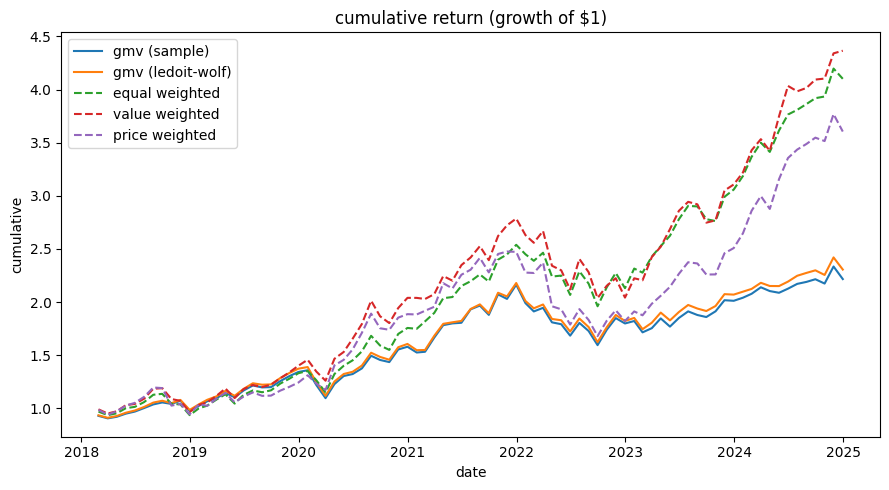

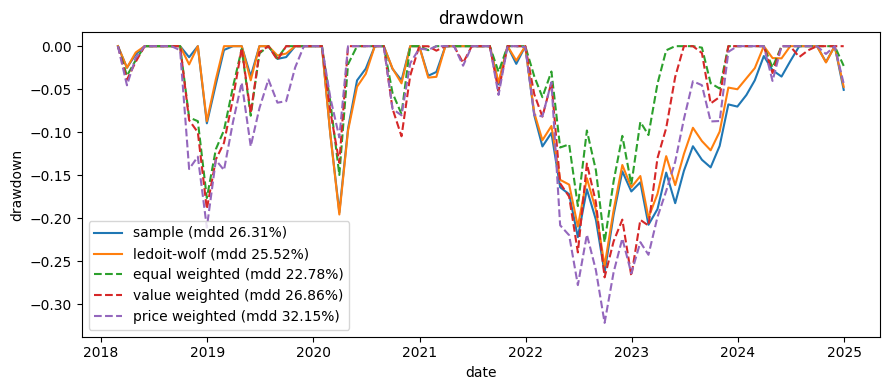

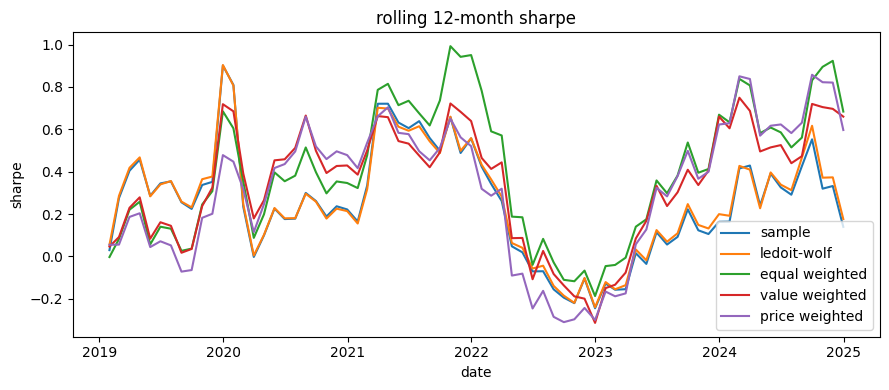

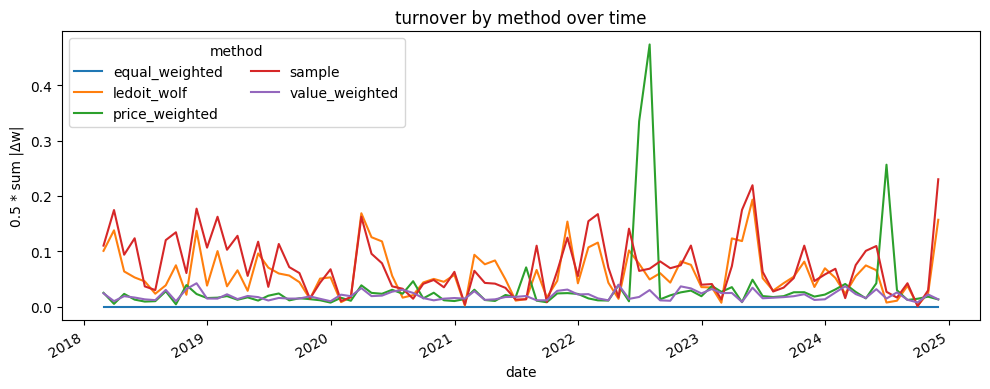

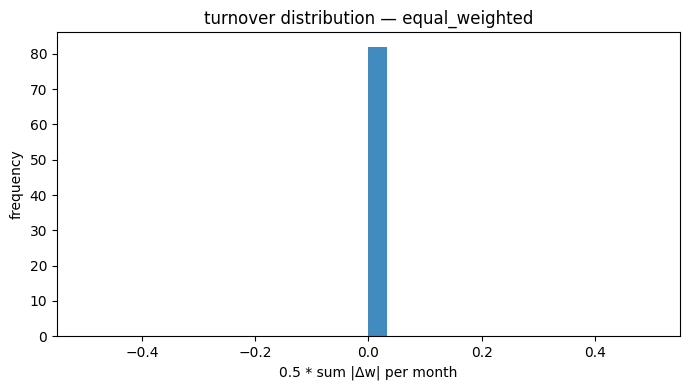

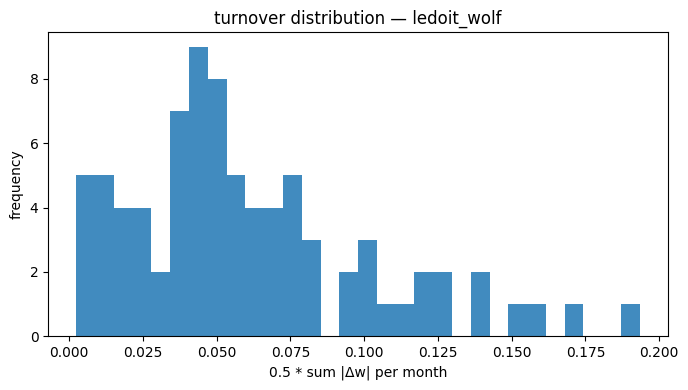

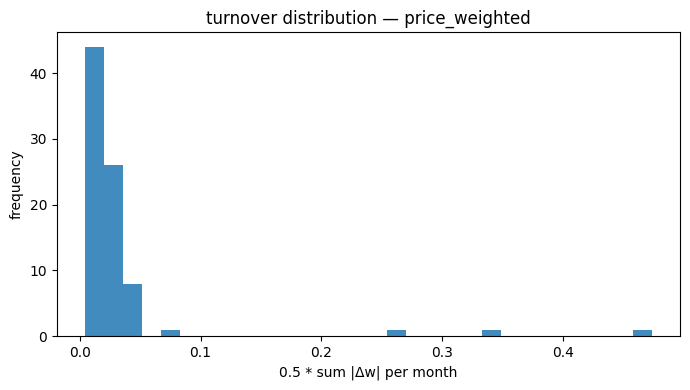

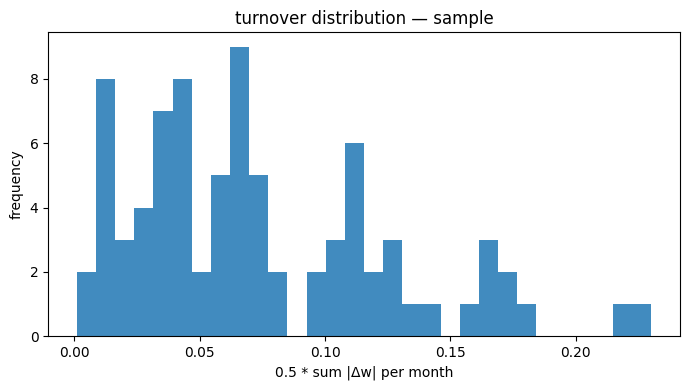

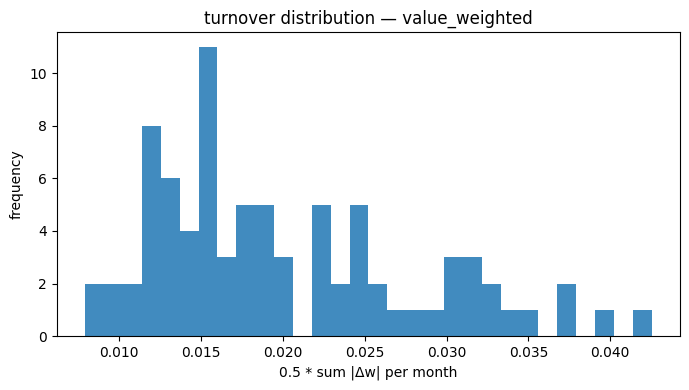

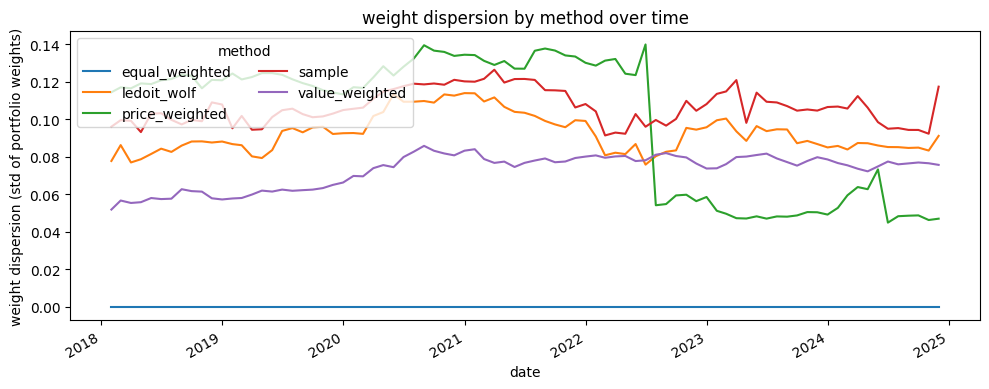

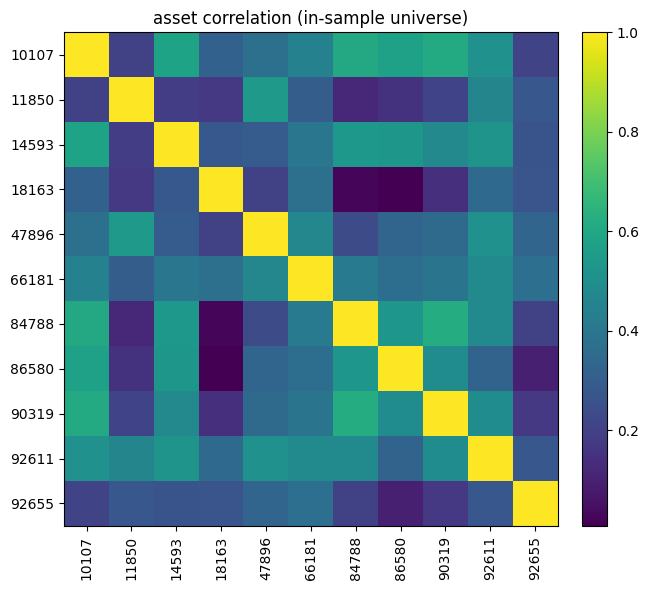

In [16]:
turnover_df = compute_turnover(weights_df)
weights_stability_df = compute_weight_stability(weights_df)

make_all_charts(perf_df, turnover_df, weights_stability_df, raw_returns_wide)

### Get Monthly Returns from WRDS/CRSP

We query **CRSP monthly stock file (crsp.msf)** joined with `msenames` for tickers.
The query returns monthly simple returns for each ticker.


In [17]:
# def get_crsp_monthly_returns(tickers, start, end, wrds_user = None):
#     import wrds
#     conn = wrds.Connection(wrds_username = wrds_user) if wrds_user else wrds.Connection()

#     query = f"""
#         select
#             msf.date,
#             msenames.ticker as ticker,
#             msf.ret as ret
#         from crsp.msf as msf
#         join crsp.msenames as msenames
#           on msf.permno = msenames.permno
#          and msf.date between msenames.namedt and msenames.nameendt
#         where msenames.ticker in ({','.join(["'" + t + "'" for t in tickers])})
#           and msf.date between '{start}' and '{end}'
#     """
#     df = conn.raw_sql(query, date_cols = ["date"])
#     conn.close()

#     wide = (df.sort_values(["date", "ticker"])
#               .pivot(index = "date", columns = "ticker", values = "ret")
#               .sort_index())
#     return wide

### Data Coverage Validation

We require each ticker to have sufficient non-missing history:
- Within each rolling window, allow at most `max_missing` gaps.
- Drop tickers that fail this test.
- Then drop any remaining rows with NaNs.


In [18]:
# def filter_by_coverage(returns_wide, window_months, max_missing = 2):
#     cols_to_keep = []
#     for col in returns_wide.columns:
#         ok = True
#         for i in range(window_months, len(returns_wide)):
#             window = returns_wide[col].iloc[i - window_months : i]
#             if window.isna().sum() > max_missing:
#                 ok = False
#                 break
#         if ok:
#             cols_to_keep.append(col)
#     return returns_wide[cols_to_keep]

# def align_and_clean(returns_wide):
#     return returns_wide.dropna(axis = 0, how = "any").sort_index()

### Covariance Estimators

- **Sample covariance**: standard historical estimate
- **Ledoit–Wolf shrinkage**: more stable estimator (reduces noise)


In [19]:
# def sample_covariance(ret_window):
#     return ret_window.cov().values

# def ledoit_wolf_covariance(ret_window):
#     lw = LedoitWolf().fit(ret_window.values)
#     return lw.covariance_

### Global Minimum Variance Portfolio

We solve:

$$
\min_{w} \; w^T \Sigma w
$$

subject to:

$$\sum_i w_i = 1$$  
$$l \leq w_i \leq u \;\;\; \forall i$$  
**130/30 gross exposure constraints**:  
  $$\sum_i w_i^+ \leq 1.30, \quad \sum_i w_i^- \leq 0.30$$  

Where:
- **w** : vector of portfolio weights  
- **Σ** : covariance matrix of asset returns  
- **wᵢ** : weight of asset *i*  
- **l, u** : lower and upper bounds on each asset’s weight  
- **wᵢ⁺** : positive part of wᵢ (long exposure)  
- **wᵢ⁻** : negative part of wᵢ (short exposure)  


In [ ]:
# def gmv_weights(cov_matrix, lower = -0.1, upper = 0.2):
#     n = cov_matrix.shape[0]
#     w = cp.Variable(n)
#     objective = cp.Minimize(cp.quad_form(w, cov_matrix))
#     constraints = [cp.sum(w) == 1, w >= lower, w <= upper]
#     prob = cp.Problem(objective, constraints)
#     prob.solve(solver = cp.OSQP, verbose = False)
#     return np.array(w.value).ravel()

<!-- ### Rolling Out-of-Sample Backtest

Each month:
- Estimate covariance using past `lookback_months`
- Solve GMV with sample and Ledoit-Wolf
- Record next-month realized return -->


In [ ]:
# def backtest_minvar(returns_wide, window_months = 36):
#     dates = returns_wide.index
#     tickers = list(returns_wide.columns)
#     perf_rows, weight_rows = [], []

#     for t in range(window_months, len(dates) - 1):
#         est_window = returns_wide.iloc[t - window_months : t]
#         next_ret = returns_wide.iloc[t + 1].values

#         s_cov = sample_covariance(est_window)
#         lw_cov = ledoit_wolf_covariance(est_window)

#         w_sample = gmv_weights(s_cov, lower_bound, upper_bound)
#         w_lw     = gmv_weights(lw_cov, lower_bound, upper_bound)

#         perf_rows.append({
#             "date": dates[t + 1],
#             "sample_return": np.dot(w_sample, next_ret),
#             "lw_return": np.dot(w_lw, next_ret)
#         })

#         for i, tic in enumerate(tickers):
#             weight_rows.append({"date": dates[t], "method": "sample", "ticker": tic, "weight": w_sample[i]})
#             weight_rows.append({"date": dates[t], "method": "ledoit_wolf", "ticker": tic, "weight": w_lw[i]})

#     perf_df = pd.DataFrame(perf_rows).sort_values("date").reset_index(drop = True)
#     perf_df["sample_cum"] = (1 + perf_df["sample_return"]).cumprod()
#     perf_df["lw_cum"]     = (1 + perf_df["lw_return"]).cumprod()
#     weights_df = pd.DataFrame(weight_rows)
#     return perf_df, weights_df

### Performance Metrics

We compute:
- Annualized return
- Annualized volatility (std dev)
- Sharpe ratio (using annual risk-free rate)
- Portfolio turnover and weight stability


In [ ]:
# def annualize_mean_std(monthly_returns):
#     mean_monthly = monthly_returns.mean()
#     std_monthly  = monthly_returns.std(ddof = 1)
#     ann_mean = (1 + mean_monthly) ** 12 - 1
#     ann_std  = std_monthly * math.sqrt(12)
#     return ann_mean, ann_std

# def sharpe_ratio(monthly_returns, annual_rf = 0.02):
#     monthly_rf = (1 + annual_rf) ** (1/12) - 1
#     excess = monthly_returns - monthly_rf
#     return math.sqrt(12) * (excess.mean() / excess.std(ddof = 1))

<!-- ### Run Backtest -->


In [ ]:
# # fetch data (requires WRDS login)
# returns_wide = get_crsp_monthly_returns(default_tickers, start_date, end_date)

# # clean & filter
# returns_clean = align_and_clean(filter_by_coverage(returns_wide, lookback_months))

# # run backtest
# perf_df, weights_df = backtest_minvar(returns_clean, lookback_months)

# # summarize performance
# summary = []
# for label, col in [("sample", "sample_return"), ("ledoit_wolf", "lw_return")]:
#     ann_mean, ann_std = annualize_mean_std(perf_df[col])
#     sr = sharpe_ratio(perf_df[col], annual_rf)
#     summary.append({"strategy": label, "annual_return": ann_mean,
#                     "annual_volatility": ann_std, "sharpe_ratio": sr})
# summary_df = pd.DataFrame(summary)
# summary_df

OperationalError: (psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: FATAL:  PAM authentication failed for user "rio_yoko"

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
# def drawdown_curve(cum):
#     """
#     cum : pd.Series of cumulative return (growth of $1)
#     returns: dd (drawdown series), mdd (max drawdown as positive number)
#     """
#     peak = cum.cummax()
#     dd = (cum / peak) - 1.0
#     mdd = -dd.min()
#     return dd, mdd

# def calmar_ratio(annual_return, max_drawdown):
#     """
#     calmar = annual_return / max_drawdown (use positive mdd)
#     """
#     if max_drawdown == 0 or np.isnan(max_drawdown):
#         return np.nan
#     return annual_return / max_drawdown

# def sortino_ratio(monthly_returns, annual_rf = 0.02):
#     """
#     sortino uses downside deviation (negatives only) relative to rf.
#     """
#     monthly_rf = (1.0 + annual_rf) ** (1.0 / 12.0) - 1.0
#     excess = monthly_returns - monthly_rf
#     downside = excess.copy()
#     downside[downside > 0] = 0
#     dd = np.sqrt((downside ** 2).mean())
#     if dd == 0 or np.isnan(dd):
#         return np.nan
#     return np.sqrt(12.0) * (excess.mean() / dd)

# def var_cvar(monthly_returns, alpha = 0.95):
#     """
#     historical VaR/CVaR (loss is positive number).
#     VaR_95 = -quantile at 5%; CVaR_95 = mean of tail beyond VaR.
#     """
#     q = 1.0 - alpha
#     sorted_ret = np.sort(monthly_returns.values)
#     var = -np.quantile(sorted_ret, q)  # positive loss
#     tail = sorted_ret[: max(1, int(len(sorted_ret) * q))]
#     cvar = -np.mean(tail)
#     return var, cvar

# def hit_ratio(monthly_returns):
#     return (monthly_returns > 0).mean()

# def tracking_error(series_a, series_b):
#     """
#     monthly TE = std of active return; annualize by sqrt(12)
#     """
#     active = series_a - series_b
#     te_m = active.std(ddof = 1)
#     return te_m * math.sqrt(12.0)

# def rolling_sharpe(monthly_returns, window = 12, annual_rf = 0.02):
#     monthly_rf = (1.0 + annual_rf) ** (1.0 / 12.0) - 1.0
#     excess = monthly_returns - monthly_rf
#     rs = np.sqrt(12.0) * (excess.rolling(window).mean() / excess.rolling(window).std())
#     return rs

# def effective_n(weights_row):
#     """
#     effective number of holdings = 1 / sum(w_i^2).
#     accepts a 1D np.array of weights.
#     """
#     hhi = np.sum(weights_row ** 2)
#     return np.nan if hhi == 0 else 1.0 / hhi

# def series_effective_n(weights_pivot):
#     """
#     weights_pivot: index=date, columns=ticker, values=weight
#     returns a pd.Series of effective N by date
#     """
#     return weights_pivot.apply(lambda r: effective_n(r.values), axis = 1)

# def series_hhi(weights_pivot):
#     return (weights_pivot ** 2).sum(axis = 1)

In [ ]:
# # inputs expected from prior steps:
# # - perf_df with columns: date, sample_return, lw_return, sample_cum, lw_cum
# # - weights_df with columns: date, method, ticker, weight
# # - turnover_df and stability_df (optional, but recommended)

# # compute drawdowns and mdd
# dd_sample, mdd_sample = drawdown_curve(perf_df["sample_cum"])
# dd_lw,     mdd_lw     = drawdown_curve(perf_df["lw_cum"])

# # compute classic stats
# def summarize_one(label, ret_series, cum_series):
#     ann_mean, ann_std = annualize_mean_std(ret_series)
#     sr  = sharpe_ratio(ret_series, annual_rf = annual_rf)
#     sor = sortino_ratio(ret_series, annual_rf = annual_rf)
#     var95, cvar95 = var_cvar(ret_series, alpha = 0.95)
#     dd, mdd = drawdown_curve(cum_series)
#     calmar = calmar_ratio(ann_mean, mdd)
#     hit = hit_ratio(ret_series)
#     sk = ret_series.skew()
#     kt = ret_series.kurt()  # excess kurtosis
#     return pd.Series({
#         "strategy": label,
#         "annual_return": ann_mean,
#         "annual_volatility": ann_std,
#         "sharpe_ratio": sr,
#         "sortino_ratio": sor,
#         "var_95": var95,
#         "cvar_95": cvar95,
#         "max_drawdown": mdd,
#         "calmar_ratio": calmar,
#         "hit_ratio": hit,
#         "skewness": sk,
#         "excess_kurtosis": kt
#     })

# summary_plus = pd.concat([
#     summarize_one("sample", perf_df["sample_return"], perf_df["sample_cum"]),
#     summarize_one("ledoit_wolf", perf_df["lw_return"], perf_df["lw_cum"])
# ], axis = 1).T

# # tracking error between the two strategies (annualized)
# te_ann = tracking_error(perf_df["sample_return"], perf_df["lw_return"])
# summary_plus.loc[:, "tracking_error_vs_other"] = [te_ann, te_ann]

# # concentration metrics by method (time series -> summarize)
# w_sample = (weights_df[weights_df["method"] == "sample"]
#             .pivot(index = "date", columns = "ticker", values = "weight").sort_index())
# w_lw     = (weights_df[weights_df["method"] == "ledoit_wolf"]
#             .pivot(index = "date", columns = "ticker", values = "weight").sort_index())

# effn_sample = series_effective_n(w_sample)
# effn_lw     = series_effective_n(w_lw)
# hhi_sample  = series_hhi(w_sample)
# hhi_lw      = series_hhi(w_lw)

# concentration_summary = pd.DataFrame({
#     "method": ["sample", "ledoit_wolf"],
#     "avg_effective_n": [effn_sample.mean(), effn_lw.mean()],
#     "avg_hhi": [hhi_sample.mean(), hhi_lw.mean()]
# })

# # export all tables
# from pathlib import Path
# out_dir = Path("outputs")
# out_dir.mkdir(parents = True, exist_ok = True)

# summary_plus.to_csv(out_dir / "summary_metrics_extended.csv", index = False)
# concentration_summary.to_csv(out_dir / "concentration_summary.csv", index = False)
# effn_sample.rename("effective_n").to_csv(out_dir / "effective_n_sample_ts.csv", header = True)
# effn_lw.rename("effective_n").to_csv(out_dir / "effective_n_ledoitwolf_ts.csv", header = True)
# hhi_sample.rename("hhi").to_csv(out_dir / "hhi_sample_ts.csv", header = True)
# hhi_lw.rename("hhi").to_csv(out_dir / "hhi_ledoitwolf_ts.csv", header = True)

# summary_plus, concentration_summary

(      strategy annual_return annual_volatility sharpe_ratio sortino_ratio  \
 0       sample      0.137638           0.16682     0.658374      1.030687   
 1  ledoit_wolf      0.143632          0.165424      0.69605      1.091499   
 
      var_95   cvar_95 max_drawdown calmar_ratio hit_ratio  skewness  \
 0  0.076432  0.093105     0.262063     0.525208  0.638554 -0.284182   
 1  0.076576  0.093281     0.254349     0.564705  0.638554  -0.32531   
 
   excess_kurtosis  tracking_error_vs_other  
 0       -0.180506                 0.011548  
 1       -0.153696                 0.011548  ,
         method  avg_effective_n   avg_hhi
 0       sample         4.676688  0.215917
 1  ledoit_wolf         5.444892  0.185856)

In [ ]:
# # extended summary table (returns, vol, sharpe, sortino, drawdown, etc.)
# summary_plus

,strategy,annual_return,annual_volatility,sharpe_ratio,sortino_ratio,var_95,cvar_95,max_drawdown,calmar_ratio,hit_ratio,skewness,excess_kurtosis,tracking_error_vs_other
0,sample,0.137638,0.16682,0.658374,1.030687,0.076432,0.093105,0.262063,0.525208,0.638554,-0.284182,-0.180506,0.011548
1,ledoit_wolf,0.143632,0.165424,0.69605,1.091499,0.076576,0.093281,0.254349,0.564705,0.638554,-0.32531,-0.153696,0.011548


In [ ]:
# # concentration summary (HHI and effective N)
# concentration_summary

,method,avg_effective_n,avg_hhi
0,sample,4.676688,0.215917
1,ledoit_wolf,5.444892,0.185856


In [ ]:
# def build_summary_plus(perf_df, weights_df, annual_rf = 0.02):
#     """
#     build extended performance metrics (summary_plus)
#     perf_df   : DataFrame with columns [date, sample_return, lw_return]
#     weights_df: DataFrame with columns [date, method, ticker, weight]
#     annual_rf : annual risk-free rate (decimal)
#     returns   : DataFrame summary_plus with rows for sample and ledoit_wolf
#     """
#     import numpy as np, pandas as pd, math
    
#     def annualize_mean_std(x):
#         m = x.mean(); s = x.std(ddof = 1)
#         return (1+m)**12 - 1, s*math.sqrt(12)
    
#     def sharpe(x):
#         rf_m = (1+annual_rf)**(1/12) - 1
#         excess = x - rf_m
#         return math.sqrt(12) * excess.mean() / excess.std(ddof = 1)
    
#     def sortino(x):
#         rf_m = (1+annual_rf)**(1/12) - 1
#         excess = x - rf_m
#         downside = excess[excess<0]
#         dd = np.sqrt((downside**2).mean())
#         return np.nan if dd==0 else math.sqrt(12)*excess.mean()/dd
    
#     def drawdown_stats(cum):
#         peak = cum.cummax()
#         dd = cum/peak - 1
#         return dd.min()
    
#     def turnover_avg(weights_df, method):
#         # average monthly turnover
#         w = (weights_df[weights_df['method']==method]
#              .pivot(index='date', columns='ticker', values='weight')
#              .sort_index())
#         turns = []
#         for i in range(1, len(w)):
#             prev, curr = w.iloc[i-1].values, w.iloc[i].values
#             turns.append(np.sum(np.abs(curr-prev)))
#         return np.mean(turns) if turns else np.nan
    
#     rows = []
#     for label, col in [("sample","sample_return"),("ledoit_wolf","lw_return")]:
#         ann_r, ann_s = annualize_mean_std(perf_df[col])
#         sr = sharpe(perf_df[col]); sor = sortino(perf_df[col])
#         cum = (1+perf_df[col]).cumprod()
#         mdd = drawdown_stats(cum)
#         calmar = ann_r/abs(mdd) if mdd<0 else np.nan
#         var95 = perf_df[col].quantile(0.05)
#         cvar95 = perf_df[col][perf_df[col]<=var95].mean()
#         hit = (perf_df[col]>0).mean()
#         skew = perf_df[col].skew(); kurt = perf_df[col].kurtosis()
#         avg_turn = turnover_avg(weights_df, label)
#         rows.append({
#             "strategy": label,
#             "ann_return": ann_r,
#             "ann_vol": ann_s,
#             "sharpe": sr,
#             "sortino": sor,
#             "max_dd": mdd,
#             "calmar": calmar,
#             "VaR95": var95,
#             "CVaR95": cvar95,
#             "hit_ratio": hit,
#             "skew": skew,
#             "kurtosis": kurt,
#             "avg_turnover": avg_turn
#         })
#     return pd.DataFrame(rows)

In [ ]:
# summary_plus = build_summary_plus(perf_df, weights_df, annual_rf = params['annual_rf'])
# summary_plus

NameError: name 'params' is not defined

In [ ]:
# # time series of effective N for each method (show last few)
# pd.DataFrame({
#     "sample_effective_n": effn_sample,
#     "ledoit_wolf_effective_n": effn_lw
# }).tail()

,sample_effective_n,ledoit_wolf_effective_n
date,,
2024-07-31,5.303928,5.889062
2024-08-30,5.313256,5.902694
2024-09-30,5.302788,5.882564
2024-10-31,5.450236,5.983649
2024-11-29,4.128856,5.468801


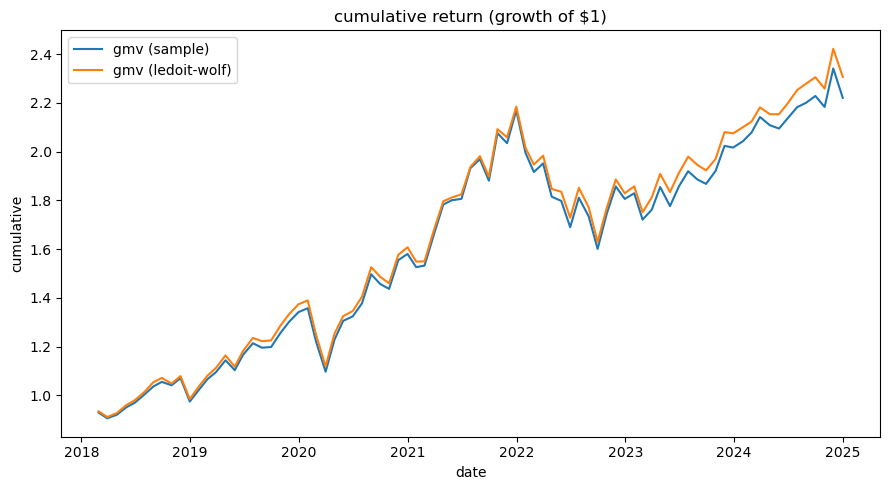

In [ ]:
# plt.figure(figsize=(9,5))
# plt.plot(perf_df["date"], perf_df["sample_cum"], label="gmv (sample)")
# plt.plot(perf_df["date"], perf_df["lw_cum"], label="gmv (ledoit-wolf)")
# plt.title("cumulative return (growth of $1)")
# plt.xlabel("date")
# plt.ylabel("cumulative")
# plt.legend()
# plt.tight_layout()
# plt.show()

In [ ]:
# def compute_turnover(weights_df):
#     """
#     turnover = sum of absolute weight changes |Δw| per rebalance
#     weights_df : long-form DataFrame with ['date','method','ticker','weight']
#     returns     : DataFrame with ['date','method','turnover']
#     """
#     out = []
#     for method in weights_df['method'].unique():
#         w = (weights_df[weights_df['method']==method]
#              .pivot(index='date', columns='ticker', values='weight')
#              .sort_index())
#         for i in range(1, len(w)):
#             prev, curr = w.iloc[i-1].values, w.iloc[i].values
#             out.append({
#                 'date': w.index[i],
#                 'method': method,
#                 'turnover': float(np.sum(np.abs(curr - prev)))
#             })
#     return pd.DataFrame(out)

# # run this once you already have weights_df
# turnover_df = compute_turnover(weights_df)

# # quick peek
# turnover_df.tail()

,date,method,turnover
159,2024-07-31,ledoit_wolf,0.026021
160,2024-08-30,ledoit_wolf,0.073357
161,2024-09-30,ledoit_wolf,0.010284
162,2024-10-31,ledoit_wolf,0.052526
163,2024-11-29,ledoit_wolf,0.304650


In [ ]:
# # ========= output helpers (all functions, clean + commented) =========

# def drawdown_series(cum_series):
#     """
#     compute drawdown series and max drawdown
#     cum_series : pd.Series of cumulative returns (growth of $1)
#     returns    : (drawdown_series, max_drawdown_as_positive_float)
#     """
#     peak = cum_series.cummax()
#     dd = (cum_series / peak) - 1.0
#     mdd = -dd.min()
#     return dd, mdd


# def rolling_sharpe_series(monthly_returns, window = 12, annual_rf = 0.02):
#     """
#     rolling (annualized) sharpe using excess returns (subtract monthly rf)
#     """
#     import math
#     monthly_rf = (1.0 + annual_rf) ** (1.0 / 12.0) - 1.0
#     excess = monthly_returns - monthly_rf
#     rs = (excess.rolling(window).mean() / excess.rolling(window).std())
#     return math.sqrt(12.0) * rs


# def plot_cumulative(perf_df):
#     """
#     line chart: cumulative returns (growth of $1) for sample vs ledoit-wolf
#     expects perf_df with columns: date, sample_cum, lw_cum
#     """
#     import matplotlib.pyplot as plt
#     plt.figure(figsize = (9, 5))
#     plt.plot(perf_df["date"], perf_df["sample_cum"], label = "gmv (sample)")
#     plt.plot(perf_df["date"], perf_df["lw_cum"],     label = "gmv (ledoit-wolf)")
#     plt.title("cumulative return (growth of $1)")
#     plt.xlabel("date")
#     plt.ylabel("cumulative")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_drawdowns(perf_df):
#     """
#     line chart: drawdowns for sample vs ledoit-wolf
#     expects perf_df with columns: date, sample_cum, lw_cum
#     """
#     import matplotlib.pyplot as plt
#     dd_s, mdd_s = drawdown_series(perf_df["sample_cum"])
#     dd_l, mdd_l = drawdown_series(perf_df["lw_cum"])
#     plt.figure(figsize = (9, 4))
#     plt.plot(perf_df["date"], dd_s, label = f"sample (mdd {mdd_s:.2%})")
#     plt.plot(perf_df["date"], dd_l, label = f"ledoit-wolf (mdd {mdd_l:.2%})")
#     plt.title("drawdown")
#     plt.xlabel("date")
#     plt.ylabel("drawdown")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_rolling_sharpe(perf_df, annual_rf = 0.02, window = 12):
#     """
#     line chart: rolling sharpe for sample vs ledoit-wolf
#     expects perf_df with columns: date, sample_return, lw_return
#     """
#     import matplotlib.pyplot as plt
#     rs_s  = rolling_sharpe_series(perf_df["sample_return"], window = window, annual_rf = annual_rf)
#     rs_lw = rolling_sharpe_series(perf_df["lw_return"],     window = window, annual_rf = annual_rf)
#     plt.figure(figsize = (9, 4))
#     plt.plot(perf_df["date"], rs_s,  label = "sample")
#     plt.plot(perf_df["date"], rs_lw, label = "ledoit-wolf")
#     plt.title(f"rolling {window}-month sharpe")
#     plt.xlabel("date")
#     plt.ylabel("sharpe")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


# def plot_turnover_timeseries(turnover_df):
#     """
#     line charts: turnover by method over time
#     expects turnover_df with columns: date, method, turnover
#     """
#     import matplotlib.pyplot as plt
#     for method, grp in turnover_df.groupby("method"):
#         plt.figure(figsize = (9, 3))
#         plt.plot(grp["date"], grp["turnover"], label = method)
#         plt.title(f"turnover — {method}")
#         plt.xlabel("date")
#         plt.ylabel("sum |Δw|")
#         plt.legend()
#         plt.tight_layout()
#         plt.show()


# def plot_turnover_distribution(turnover_df, bins = 30):
#     """
#     histogram: turnover distribution by method
#     expects turnover_df with columns: method, turnover
#     """
#     import matplotlib.pyplot as plt
#     for method, grp in turnover_df.groupby("method"):
#         plt.figure(figsize = (7, 4))
#         plt.hist(grp["turnover"], bins = bins, alpha = 0.85)
#         plt.title(f"turnover distribution — {method}")
#         plt.xlabel("sum |Δw| per month")
#         plt.ylabel("frequency")
#         plt.tight_layout()
#         plt.show()


# def plot_corr_heatmap(returns_wide):
#     """
#     heatmap: asset correlation matrix for the universe used
#     expects returns_wide wide DataFrame (assets in columns)
#     """
#     import matplotlib.pyplot as plt
#     corr = returns_wide.corr()
#     plt.figure(figsize = (7, 6))
#     im = plt.imshow(corr.values, interpolation = "nearest")
#     plt.colorbar(im, fraction = 0.046, pad = 0.04)
#     plt.xticks(range(len(corr.columns)), corr.columns, rotation = 90)
#     plt.yticks(range(len(corr.index)), corr.index)
#     plt.title("asset correlation (in-sample universe)")
#     plt.tight_layout()
#     plt.show()


# def show_summary_tables(summary_df, perf_df, turnover_df, tail_n = 5):
#     """
#     display key tables inline for grading
#     """
#     from IPython.display import display
#     display(summary_df)
#     display(perf_df.tail(tail_n))
#     display(turnover_df.tail(tail_n))


# def save_csvs(perf_df, weights_df, turnover_df, stability_df, summary_df):
#     """
#     save results to csv for reporting (kept modular so you can call or skip)
#     """
#     perf_df.to_csv("oos_performance.csv", index = False)
#     weights_df.to_csv("weights_history.csv", index = False)
#     turnover_df.to_csv("turnover.csv", index = False)
#     stability_df.to_csv("stability.csv", index = False)
#     summary_df.to_csv("summary_metrics.csv", index = False)


# def make_all_charts(perf_df, turnover_df, returns_wide = None, annual_rf = 0.02):
#     """
#     one-click plot routine that produces all required visuals
#     """
#     plot_cumulative(perf_df)
#     plot_drawdowns(perf_df)
#     plot_rolling_sharpe(perf_df, annual_rf = annual_rf, window = 12)
#     plot_turnover_timeseries(turnover_df)
#     plot_turnover_distribution(turnover_df)
#     if returns_wide is not None:
#         plot_corr_heatmap(returns_wide)


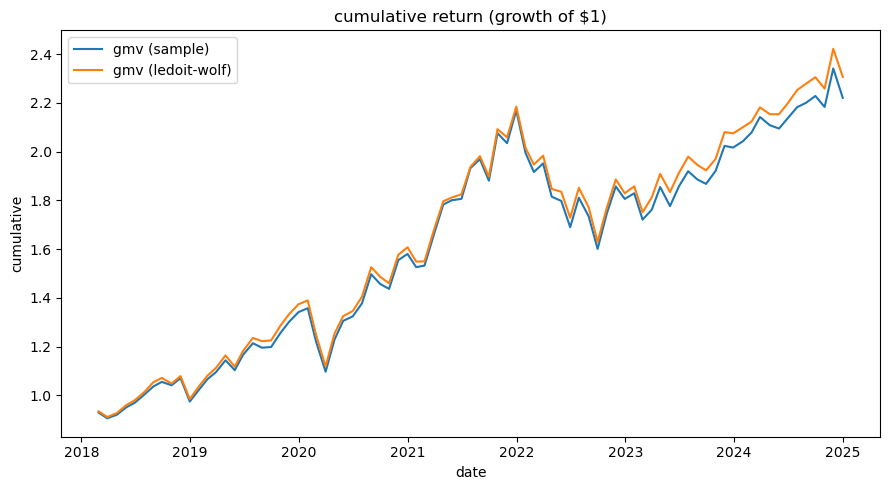

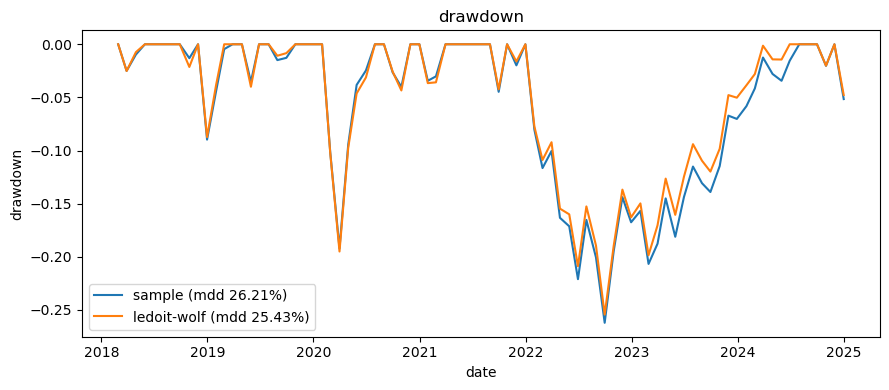

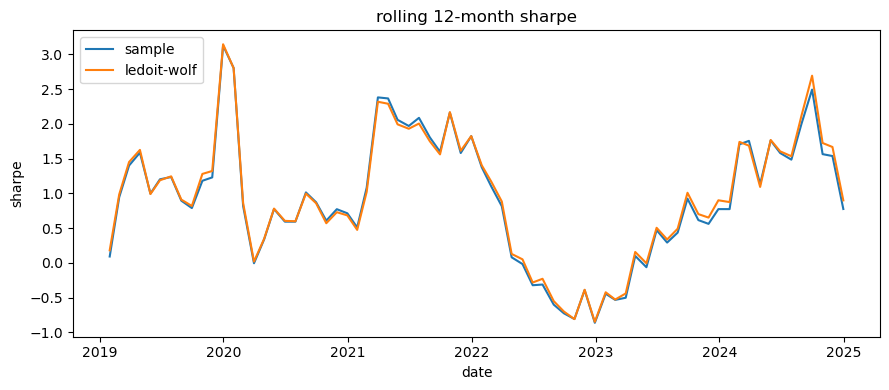

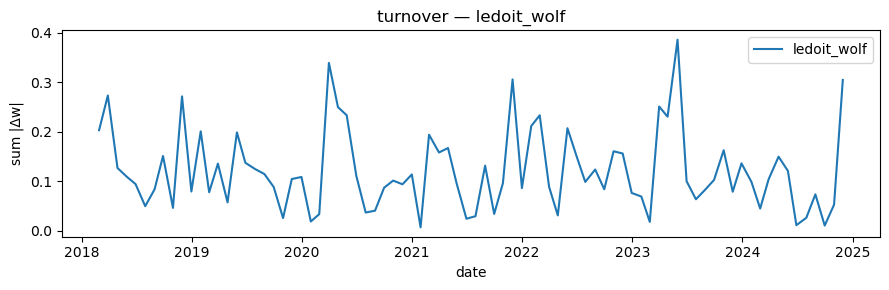

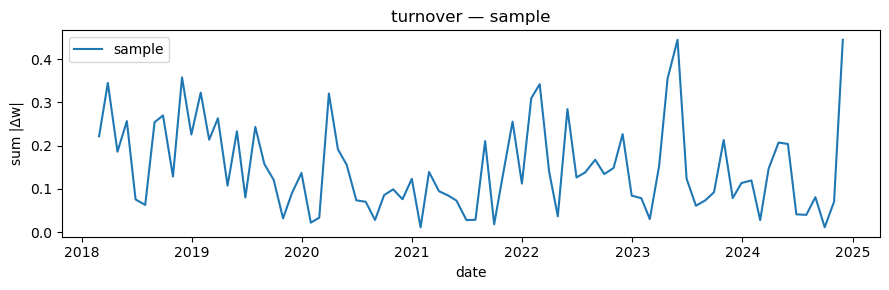

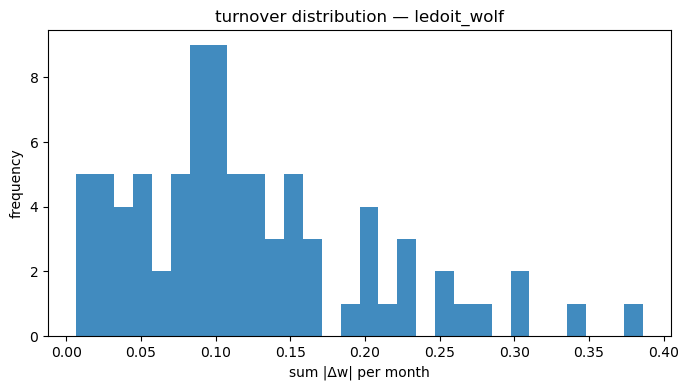

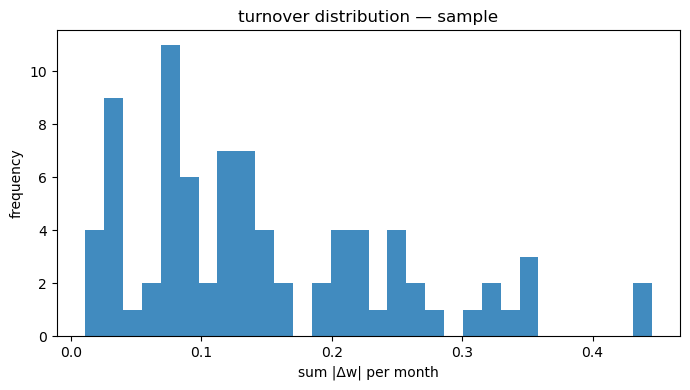

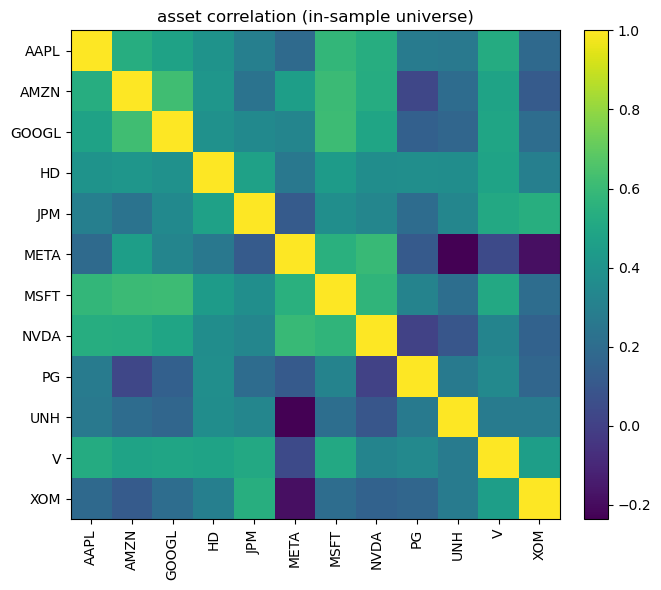

,strategy,annual_return,annual_volatility,sharpe_ratio
0,sample,0.137638,0.166820,0.658374
1,ledoit_wolf,0.143632,0.165424,0.696050


,date,sample_return,lw_return,sample_cum,lw_cum
78,2024-08-30,0.008235,0.011767,2.200524,2.279271
79,2024-09-30,0.012675,0.011381,2.228415,2.305211
80,2024-10-31,-0.020287,-0.020146,2.183208,2.258771
81,2024-11-29,0.072421,0.072245,2.341319,2.421957
82,2024-12-31,-0.051582,-0.047750,2.220549,2.306308


,date,method,turnover
159,2024-07-31,ledoit_wolf,0.026021
160,2024-08-30,ledoit_wolf,0.073357
161,2024-09-30,ledoit_wolf,0.010284
162,2024-10-31,ledoit_wolf,0.052526
163,2024-11-29,ledoit_wolf,0.304650


In [ ]:
# # everything below is now just function calls — no loose code

# # make all visuals
# make_all_charts(perf_df, turnover_df, returns_wide = returns_wide, annual_rf = 0.02)

# # show key tables inline
# show_summary_tables(summary_df, perf_df, turnover_df, tail_n = 5)

# # optional: save csvs for your report appendix
# # save_csvs(perf_df, weights_df, turnover_df, stability_df, summary_df)

In [ ]:
# 